In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### <font color='red'>AI001 - Find Suitable Dataset</font>

In [ ]:
%%capture

from datasets import load_dataset
help(load_dataset)

mode = 'force_redownload'

train_data = load_dataset('md_gender_bias', name = 'funpedia', split = 'train', download_mode = mode)
test_data = load_dataset('md_gender_bias', name = 'funpedia', split = 'test', download_mode = mode)
val_data = load_dataset('md_gender_bias', name = 'funpedia', split = 'validation', download_mode = mode)

In [ ]:
print(train_data)
print(test_data)
print(val_data)

Dataset({
    features: ['text', 'gender', 'title', 'persona'],
    num_rows: 23897
})
Dataset({
    features: ['text', 'gender', 'title', 'persona'],
    num_rows: 2938
})
Dataset({
    features: ['text', 'gender', 'title', 'persona'],
    num_rows: 2984
})


In [ ]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
val_data = pd.DataFrame(val_data)

In [ ]:
total_nrows = len(train_data) + len(test_data) + len(val_data)
print('percentage data that is TRAIN:', round((len(train_data)/total_nrows)*100, 2))
print('percentage data that is TEST:', round((len(test_data)/total_nrows)*100, 2))
print('percentage data that is VALIDATION:', round((len(val_data)/total_nrows)*100, 2))

percentage data that is TRAIN: 80.14
percentage data that is TEST: 9.85
percentage data that is VALIDATION: 10.01


#### Load data locally (if need be)

In [ ]:
#data source: https://huggingface.co/datasets/md_gender_bias
#train_data = pd.read_json('md_gender_bias/funpedia/train.jsonl', lines = True)
#test_data = pd.read_json('md_gender_bias/funpedia/test.jsonl', lines = True)
#val_data = pd.read_json('md_gender_bias/funpedia/valid.jsonl', lines = True)

### <font color='red'>AI002 - EDA (Exploratory Data Analysis)</font>

In [ ]:
train_data.head(3)

,text,gender,title,persona
0,Max Landis is a comic book writer who wrote Ch...,male,Max Landis,Humorous
1,Félix stevens is a retired cuban sprinter who ...,male,Félix Stevens,Confident
2,Arthur Engelbert is a professor at the Univers...,male,Arthur Engelbert,Creative


In [ ]:
test_data.head(3)

,text,gender,title,persona
0,Hmmm yes Horacio Calcaterra is a sportsman tha...,male,Horacio Calcaterra,"Articulate (Well-spoken, Expressive)"
1,John A. Fallon kindly accepted his appointment...,male,John A. Fallon,Humble
2,Arthur Knight sadly passed as a result of part...,male,Arthur Gerald Knight,Peaceful


In [ ]:
val_data.head(3)

,text,gender,title,persona
0,I wonder what went through Bill Tom Closs's mi...,male,Bill Closs,Deep
1,Gerald Rashard Everett is a football tight end...,male,Gerald Everett,Playful
2,The Nahoni Range is a mountan range that is lo...,male,Nahoni Range,Creative


In [ ]:
train_data.tail(15)

,text,gender,title,persona
23882,Jesse Gress is an amazing rock guitarist!,male,Jesse Gress,Energetic
23883,I wonder how Elam Stevenson's life would have ...,male,Elam Stevenson,Reflective
23884,"If you seek the Olga Kostenko, you must go to ...",female,Olga Kostenko,Insightful
23885,Even though Charles A. Hickey had a great care...,male,Charles A. Hickey,Empathetic
23886,P. Frank Winkler a well known astro careerist ...,male,Frank Winkler,Insightful
23887,"This concert pianist, Edward Cahill's music wa...",male,Edward Cahill (pianist),Warm
23888,Your heart will be touched by the personal sto...,gender-neutral,Michèle Stephenson,"Compassionate (Sympathetic, Warm)"
23889,"John Boning played in 35 matches, totalling 65...",male,John Boning,Practical
23890,Katie spencer has worked many films with sarah...,female,Katie Spencer,Scholarly
23891,English Crickiter Ian Burnley was born 03/11/1...,male,Ian Burnley,Exciting


In [ ]:
train_data['gender'].value_counts()

male              19156
female             3594
gender-neutral     1147
Name: gender, dtype: int64

In [ ]:
train_data.sample(5)

,text,gender,title,persona
3631,The Guatemalan feminist Irene de Peyre was an ...,female,Irene de Peyré,"Articulate (Well-spoken, Expressive)"
8783,Leo Murphy who played for Hawthorn was my gran...,male,Leo Murphy,"Contemplative (Reflective, Thoughtful)"
18860,The English cricketer David Rooney was born in...,male,David Rooney (cricketer),Spirited
9280,You can't strike out with an MLB Twins catcher...,male,Jason Castro (baseball),Witty
8164,Rudi Gering had performed admirably and deserv...,male,Rudi Gering,Rational


In [ ]:
train_data.head()

,text,gender,title,persona
0,Max Landis is a comic book writer who wrote Ch...,male,Max Landis,Humorous
1,Félix stevens is a retired cuban sprinter who ...,male,Félix Stevens,Confident
2,Arthur Engelbert is a professor at the Univers...,male,Arthur Engelbert,Creative
3,Danielle Frenkel is a high jumper born in Israel,female,Danielle Frenkel,Brilliant
4,Ernie O'Malley served in the Irish republican ...,male,Ernie O'Malley,Gentle


In [ ]:
test_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2938 non-null   object
 1   gender   2938 non-null   object
 2   title    2938 non-null   object
 3   persona  2938 non-null   object
dtypes: object(4)
memory usage: 91.9+ KB


In [ ]:
#combine pre-split datasets into one then apply train test split function twice
unified_data = train_data.append(test_data, ignore_index=True)
unified_data = unified_data.append(val_data, ignore_index=True)
print('nrows raw unified dataset:', len(unified_data))

nrows raw unified dataset: 29819


In [ ]:
unified_data.head(1)

,text,gender,title,persona
0,Max Landis is a comic book writer who wrote Ch...,male,Max Landis,Humorous


In [ ]:
#drop all columns except text and label
unified_data = unified_data[['text', 'gender']]

In [ ]:
unified_data.head(1)

,text,gender
0,Max Landis is a comic book writer who wrote Ch...,male


In [ ]:
#ensure all text lowercase so can compare for duplicates
for col in ['text', 'gender']:
    unified_data[col] = unified_data[col].str.lower()

In [ ]:
unified_data.head(3)

,text,gender
0,max landis is a comic book writer who wrote ch...,male
1,félix stevens is a retired cuban sprinter who ...,male
2,arthur engelbert is a professor at the univers...,male


In [ ]:
#check duplicate rows in 'text' column
print('Number of duplicates:', len(unified_data[unified_data.duplicated(['text'])]))
#drop duplicates
unified_data.drop_duplicates(subset=['text'], inplace = True)
#recheck number of duplicates
print('Number of duplicates:', len(unified_data[unified_data.duplicated(['text'])]))

Number of duplicates: 1
Number of duplicates: 0


In [ ]:
unified_data.head()

,text,gender
0,max landis is a comic book writer who wrote ch...,male
1,félix stevens is a retired cuban sprinter who ...,male
2,arthur engelbert is a professor at the univers...,male
3,danielle frenkel is a high jumper born in israel,female
4,ernie o'malley served in the irish republican ...,male


<AxesSubplot:title={'center':'UNIFIED data class counts'}>

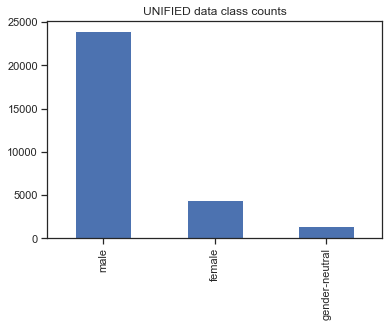

In [ ]:
unified_data['gender'].value_counts().plot(kind = 'bar', title = 'UNIFIED data class counts')

In [ ]:
class_counts_df = pd.DataFrame(unified_data['gender'].value_counts())
class_counts_df.reset_index(inplace = True)
class_counts_df.columns = ['class', 'counts']
print(class_counts_df.head())

fig = px.bar(class_counts_df, x = 'class', y = 'counts', title = 'UNIFIED data class counts')
fig.show()

            class  counts
0            male   23938
1          female    4457
2  gender-neutral    1423


to do:
- drop 'gender-neutral'
- fix considerable class imbalance between 'male' and 'female' by downsampling 'male' class
- check NAs

In [ ]:
#check NAs
class_counts_df.isna().sum()

class     0
counts    0
dtype: int64

In [ ]:
#check NAs
unified_data.isnull().sum()

text      0
gender    0
dtype: int64

In [ ]:
#drop NAs
unified_data.dropna(inplace = True)

In [ ]:
#drop 'gender-neutral' class?
unified_data = unified_data[unified_data['gender'] != 'gender-neutral']

In [ ]:
unified_data['gender'].value_counts()

male      23938
female     4457
Name: gender, dtype: int64

<AxesSubplot:title={'center':'UNIFIED data class counts'}>

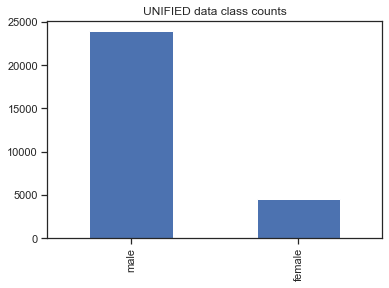

In [ ]:
unified_data['gender'].value_counts().plot(kind = 'bar', title = 'UNIFIED data class counts')

In [ ]:
#check class imbalance
print('\'male\' class is ', round(len(unified_data[unified_data['gender'] == 'male'])/len(unified_data[unified_data['gender'] == 'female']), 2), 'times larger than \'female\' class')

'male' class is  5.37 times larger than 'female' class


In [ ]:
unified_data['text'].shape

(28395,)

In [ ]:
unified_data[unified_data['gender'] == 'female'].head(10)

,text,gender
3,danielle frenkel is a high jumper born in israel,female
12,tania mihailuk is a politician who was born in...,female
13,juliet taylor is a woman who works as a castin...,female
14,margaret caroline rudd was born in britain. sh...,female
15,retta scott was an american artist who died in...,female
16,cicely mary barker was a fantasy illustrator w...,female
20,che zahara worked as a malay activist and foug...,female
21,"i feel gratitude towards evelyn dunbar, she he...",female
24,"geraldine kattnig was born on february 4, 1930...",female
28,amy thomson is a hard science fiction writing ...,female


In [ ]:
#downsample 'male' to fix class imbalance
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority', random_state= 0)
X = np.array(unified_data['text']).reshape(-1, 1)
y = np.array(unified_data['gender']).reshape(-1, 1)
X_undersample, y_undersample = undersample.fit_resample(X, y)

In [ ]:
#flatten to 1D array in order to reocmbine into a new undersampled 'unified_data' dataframe
X_undersample = X_undersample.flatten()
y_undersample = y_undersample.flatten()

In [ ]:
print(X_undersample.shape)
print(y_undersample.shape)

(8914,)
(8914,)


In [ ]:
unified_data = pd.DataFrame({'text': X_undersample, 'gender': list(y_undersample)}, columns=['text', 'gender'])

In [ ]:
unified_data.head(10)

,text,gender
0,danielle frenkel is a high jumper born in israel,female
1,tania mihailuk is a politician who was born in...,female
2,juliet taylor is a woman who works as a castin...,female
3,margaret caroline rudd was born in britain. sh...,female
4,retta scott was an american artist who died in...,female
5,cicely mary barker was a fantasy illustrator w...,female
6,che zahara worked as a malay activist and foug...,female
7,"i feel gratitude towards evelyn dunbar, she he...",female
8,"geraldine kattnig was born on february 4, 1930...",female
9,amy thomson is a hard science fiction writing ...,female


In [ ]:
#check class imbalance
print('\'male\' class is ', round(len(unified_data[unified_data['gender'] == 'male'])/len(unified_data[unified_data['gender'] == 'female']), 2), 'times larger than \'female\' class')

'male' class is  1.0 times larger than 'female' class


<AxesSubplot:title={'center':'UNIFIED data class counts'}>

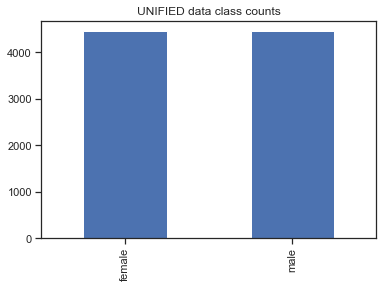

In [ ]:
#check successful downsampling (undersampling)
unified_data['gender'].value_counts().plot(kind = 'bar', title = 'UNIFIED data class counts')

In [ ]:
unified_data['text'][0]

'danielle frenkel is a high jumper born in israel'

In [ ]:
unified_data['len_text'] = 0

unified_data.head()

,text,gender,len_text
0,danielle frenkel is a high jumper born in israel,female,0
1,tania mihailuk is a politician who was born in...,female,0
2,juliet taylor is a woman who works as a castin...,female,0
3,margaret caroline rudd was born in britain. sh...,female,0
4,retta scott was an american artist who died in...,female,0


In [ ]:
len(unified_data)

8914

In [ ]:
#inefficient loop takes too long
#for row in range(0, len(unified_data)):
    #unified_data['len_text'][row] = len(unified_data['text'][row])
    
unified_data['len_text'] = unified_data['text'].str.len()

In [ ]:
unified_data['len_text'].head()

0    48
1    56
2    56
3    78
4    51
Name: len_text, dtype: int64

In [ ]:
unified_data.head(3)

,text,gender,len_text
0,danielle frenkel is a high jumper born in israel,female,48
1,tania mihailuk is a politician who was born in...,female,56
2,juliet taylor is a woman who works as a castin...,female,56


In [ ]:
unified_data.tail(3)

,text,gender,len_text
8911,john born in the great city of quebec and beca...,male,70
8912,"spending the longest time in prison, li wangya...",male,98
8913,thank you so much for letting me meet the trac...,male,66


In [ ]:
unified_data.head(200)

,text,gender,len_text
0,danielle frenkel is a high jumper born in israel,female,48
1,tania mihailuk is a politician who was born in...,female,56
2,juliet taylor is a woman who works as a castin...,female,56
3,margaret caroline rudd was born in britain. sh...,female,78
4,retta scott was an american artist who died in...,female,51
...,...,...,...
195,steliana nistor was a key member of the romani...,female,108
196,it's so interesting to read about tziporah hel...,female,113
197,"i am very involved in the cycling world, and l...",female,92
198,gina wilson was born in australia.,female,34


In [ ]:
unified_data['len_text'].value_counts()

81     139
86     135
84     133
78     132
91     131
      ... 
162      1
17       1
13       1
174      1
177      1
Name: len_text, Length: 161, dtype: int64

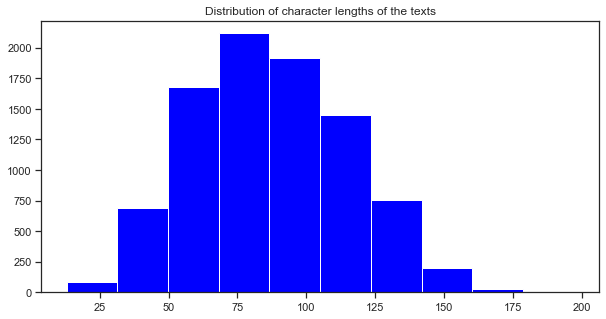

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.hist(unified_data['len_text'], color ='blue')
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title("Distribution of character lengths of the texts")
plt.show()

### <font color='red'>AI003 - Preprocess the Text and Create Text Embeddings</font>

In [ ]:
#test 'train_test_split'
X = unified_data['text']
y = unified_data['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2, stratify = y)   #'stratify' argument ensures same class proportions for each split

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [ ]:
#convert two classes to new binary id column
unified_data['gender_id'] = unified_data['gender']
unified_data['gender_id'].replace(['male', 'female'], [0, 1], inplace = True)
print(unified_data[unified_data['gender'] == 'male'].head(3))
print(unified_data[unified_data['gender'] == 'female'].head(3))

                                                   text gender  len_text  \
4457  holy moly! josh brown guest starred in the sho...   male        99   
4458  jim colver has been serving the residents of a...   male        74   
4459  born in cleveland, ford was luckily taken by t...   male       104   

      gender_id  
4457          0  
4458          0  
4459          0  
                                                text  gender  len_text  \
0   danielle frenkel is a high jumper born in israel  female        48   
1  tania mihailuk is a politician who was born in...  female        56   
2  juliet taylor is a woman who works as a castin...  female        56   

   gender_id  
0          1  
1          1  
2          1  


In [ ]:
unified_data.head()

,text,gender,len_text,gender_id
0,danielle frenkel is a high jumper born in israel,female,48,1
1,tania mihailuk is a politician who was born in...,female,56,1
2,juliet taylor is a woman who works as a castin...,female,56,1
3,margaret caroline rudd was born in britain. sh...,female,78,1
4,retta scott was an american artist who died in...,female,51,1


In [ ]:
type(unified_data['text'])

pandas.core.series.Series

In [ ]:
other_unified = unified_data.copy()

### <font color='red'>AI006 - Output Sentiment Analysis From Pretrained Model</font>

- https://towardsdatascience.com/the-most-favorable-pre-trained-sentiment-classifiers-in-python-9107c06442c6

#### Vader

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
    
    print('negative, neutral, positive, compound, overall_sentiment')
    return negative, neutral, positive, compound, overall_sentiment

In [ ]:
for i in range(0, 2 + 1):
    print('TEXT:', other_unified['text'][i], '-->', '\nSENTIMENT:', sentiment_vader(other_unified['text'][i]), '\n', '-'*30)

negative, neutral, positive, compound, overall_sentiment
TEXT: danielle frenkel is a high jumper born in israel --> 
SENTIMENT: (0.0, 1.0, 0.0, 0.0, 'Neutral') 
 ------------------------------
negative, neutral, positive, compound, overall_sentiment
TEXT: tania mihailuk is a politician who was born in australia --> 
SENTIMENT: (0.0, 1.0, 0.0, 0.0, 'Neutral') 
 ------------------------------
negative, neutral, positive, compound, overall_sentiment
TEXT: juliet taylor is a woman who works as a casting director --> 
SENTIMENT: (0.0, 1.0, 0.0, 0.0, 'Neutral') 
 ------------------------------
negative, neutral, positive, compound, overall_sentiment
TEXT: margaret caroline rudd was born in britain. she was a notorious female forger. --> 
SENTIMENT: (0.195, 0.805, 0.0, -0.4404, 'Negative') 
 ------------------------------
negative, neutral, positive, compound, overall_sentiment
TEXT: retta scott was an american artist who died in 1990 --> 
SENTIMENT: (0.286, 0.714, 0.0, -0.5574, 'Negative') 


#### TextBlob

In [ ]:
from textblob import TextBlob

#call the classifier
def sentiment_textblob(row):
  
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    subjectivity = classifier.sentiment.subjectivity
    
    print('polarity, subjectivity')
    return polarity, subjectivity

In [ ]:
for i in range(0, 2 + 1):
    print('TEXT:', other_unified['text'][i], '-->', '\nSENTIMENT:', sentiment_textblob(other_unified['text'][i]), '\n', '-'*30)

polarity, subjectivity
TEXT: danielle frenkel is a high jumper born in israel --> 
SENTIMENT: (0.16, 0.5399999999999999) 
 ------------------------------
polarity, subjectivity
TEXT: tania mihailuk is a politician who was born in australia --> 
SENTIMENT: (0.0, 0.0) 
 ------------------------------
polarity, subjectivity
TEXT: juliet taylor is a woman who works as a casting director --> 
SENTIMENT: (0.0, 0.0) 
 ------------------------------
polarity, subjectivity
TEXT: margaret caroline rudd was born in britain. she was a notorious female forger. --> 
SENTIMENT: (0.0, 0.16666666666666666) 
 ------------------------------
polarity, subjectivity
TEXT: retta scott was an american artist who died in 1990 --> 
SENTIMENT: (0.0, 0.0) 
 ------------------------------
polarity, subjectivity
TEXT: cicely mary barker was a fantasy illustrator who depicted fairies and flowers --> 
SENTIMENT: (0.0, 0.0) 
 ------------------------------


#### Happy Transformer

In [ ]:
try:
    #sentencepiece causing error 'legacy-install-failure': https://stackoverflow.com/questions/71575380/sentencepiece-library-is-not-being-installed-in-the-system
    from happytransformer import HappyTextClassification

    happy_tc = HappyTextClassification(model_type="DISTILBERT", model_name="distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)

    def sentiment_happy_transformer(text):
        result = happy_tc.classify_text(text)
        if result.label == 'LABEL_1':
            print('positive sentiment:', result.score)
        elif result.label == 'LABEL_0':
            print('negative sentiment:', result.score)
        else:
            print('neutral sentiment:', result.score)
            
    for i in range(0, 2 + 1):
        sentiment_happy_transformer(other_unified['text'][i])
        
except:
    print('install error, sentencepiece not ocmpatible with Python 3.10 seemingly')

install error, sentencepiece not ocmpatible with Python 3.10 seemingly


#### Amazon Comprehend

In [ ]:
#https://dev.classmethod.jp/articles/comprehend-operations-using-python-boto3/

import boto3

def detect_sentiment(text):
    comprehend = boto3.client('comprehend', region_name='eu-west-2')
    response = comprehend.detect_sentiment(Text=text, LanguageCode='en')
    return response

In [ ]:
for i in range(0, 2 + 1):
    print('TEXT:', other_unified['text'][i], '-->', '\nANALYSIS:\n', detect_sentiment(other_unified['text'][i]), '\n', '-'*30)

TEXT: danielle frenkel is a high jumper born in israel --> 
ANALYSIS:
 {'Sentiment': 'NEUTRAL', 'SentimentScore': {'Positive': 0.07776756584644318, 'Negative': 0.017122093588113785, 'Neutral': 0.9037699103355408, 'Mixed': 0.0013403829652816057}, 'ResponseMetadata': {'RequestId': '4c755e42-a77a-4283-9b23-03e1fe7cf4ef', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '4c755e42-a77a-4283-9b23-03e1fe7cf4ef', 'content-type': 'application/x-amz-json-1.1', 'content-length': '164', 'date': 'Mon, 18 Jul 2022 12:14:44 GMT'}, 'RetryAttempts': 0}} 
 ------------------------------
TEXT: tania mihailuk is a politician who was born in australia --> 
ANALYSIS:
 {'Sentiment': 'NEUTRAL', 'SentimentScore': {'Positive': 0.0014963001012802124, 'Negative': 0.042056210339069366, 'Neutral': 0.9535102248191833, 'Mixed': 0.0029372223652899265}, 'ResponseMetadata': {'RequestId': '0777f138-1083-46b1-8f42-38622f802744', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '0777f138-1083-46b1-8f42-

#### text2emotion

In [ ]:
#be aware, text2emotion builds on top of NLTK and so requires NLTK data downloads to work - recurring SSL CERTIFICATE VERIFY FAILED error
#I downloaded manually and stored in relevant directory
import text2emotion as te

for i in range(0, 2 + 1):
        print('TEXT:', other_unified['text'][i], '-->', '\nEMOTIONS:', te.get_emotion(other_unified['text'][i]), '\n', '-'*30)

TEXT: danielle frenkel is a high jumper born in israel --> 
EMOTIONS: {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.5, 'Fear': 0.5} 
 ------------------------------
TEXT: tania mihailuk is a politician who was born in australia --> 
EMOTIONS: {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 1.0, 'Fear': 0.0} 
 ------------------------------
TEXT: juliet taylor is a woman who works as a casting director --> 
EMOTIONS: {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.5, 'Sad': 0.0, 'Fear': 0.5} 
 ------------------------------
TEXT: margaret caroline rudd was born in britain. she was a notorious female forger. --> 
EMOTIONS: {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 1.0, 'Fear': 0.0} 
 ------------------------------
TEXT: retta scott was an american artist who died in 1990 --> 
EMOTIONS: {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 1.0} 
 ------------------------------
TEXT: cicely mary barker was a fantasy illustrator who depicted fairies and flowe